# Exporting LLM Runs and Feedback

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langsmith-cookbook/blob/main/exploratory-data-analysis/exporting-llm-runs-and-feedback/llm_run_etl.ipynb)

Understanding how your LLM app interacts with users is crucial. LangSmith offers a number of useful ways to interact with and annotate trace data directly in the app. You can also easily query that trace data so you can process it with your tool of choice.

This tutorial guides you through exporting LLM traces and associated feedback from LangSmith for further analysis. By the end, you'll be able to export a flat table of LLM run information that you can analyze, enrich, or use for model training.

Before we start, ensure you have a LangChain project with some logged traces. You can generate some using almost any of the other recipes in this cookbook. The overall steps will be:

1. Query runs, filtering by time, tags, or other attributes.
2. Add in associated feedback metrics (if captured)
3. Export to analysis tool.

To make things easy, we will be loading the data into a pandas dataframe. We will be doing the ETL on LLM runs logged from LangChain, but you can modify the code below to handle whatever schema is used by your deployed model. Now let's set up our environment!

#### Setup

First, install langsmith and pandas and set your langsmith API key to connect to your project.
We will also install LangChain to use one of its formatting utilities.


In [1]:
# %pip install -U langchain langsmith pandas seaborn --quiet

In [2]:
%env LANGCHAIN_API_KEY="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"
# %pip install --upgrade pandas

env: LANGCHAIN_API_KEY="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"


In [3]:
from langsmith import Client
import pandas as pd

client = Client()

## 1. Query Runs

Now that the environment is ready, we will load the run data from LangSmith. Let's try loading all our LLM runs from the past week. To do so, we will filter for runs with the "llm" `run_type` from the past week.

Please reference the [docs](https://docs.smith.langchain.com/tracing/faq/querying_traces) for guidance on more complex filters (using metadata, tags, and other attributes).


In [4]:
from datetime import datetime, timedelta
from datetime import timezone

UTC = timezone.utc
# or


start_time = datetime.now(UTC) - timedelta(days=4)
# model_convert, data_processing, sketch_generator
task_type = "sketch_generator"
runs = list(
    client.list_runs(
        project_name="default",
        start_time=start_time,
        end_time=datetime.now(UTC),
        # run_type="llm",
        # filter=f"and(has(tags, 'gpt-4o-mini'),has(tags, {task_type}))",
        filter=f"and(has(tags, 'gpt-4o'),has(tags, {task_type}))",
    )
)

In [5]:
print(runs[3])

IndexError: list index out of range

In [141]:
df = pd.DataFrame(
    [
        {
            "name": run.name if run.name == "sketch_generator_run" else None,
            # "id": str(run.id),  # Convert UUID to string
            "latency": (
                (run.end_time - run.start_time).total_seconds()
                if run.end_time
                else None
            ),
            "time": run.start_time,
            # "tags": ', '.join(run.tags) if run.tags else None,  # Join tags into a string
            # "run_type": run.run_type,
            "num_run": run.extra["metadata"].get(
                "num_run", None
            ),  # Use .get() with a default value
            "total_tokens": run.total_tokens,
            "input_tokens": run.prompt_tokens,
            "output_tokens": run.completion_tokens,
            "total_cost": float(run.total_cost) if run.total_cost is not None else None,
            "input_cost": (
                float(run.prompt_cost) if run.prompt_cost is not None else None
            ),
            "output_cost": (
                float(run.completion_cost) if run.completion_cost is not None else None
            ),
            "pass": (
                "no"
                if "Failed to generate valid code after the max 5 attempts"
                in str(run.error)
                else "yes"
            ),
            "task": task_type,
        }
        for run in runs
    ]
)

# display(df)
# print(df)

In [142]:
# """For Conversion"""
# df = df[df['num_run'] <= 32]
# df = df[df['total_tokens'] != 0]
# df = df[df['name'].notna()]
# df.set_index('num_run', inplace=False)

# df['output_cost'] = df['output_cost']*16.6666666667
# df['input_cost'] = df['input_cost']*16.6666666667
# df['total_cost'] = df['total_cost']*16.6666666667
# df.drop(columns="name")

# """For processing"""
# df = df[df['num_run'] <= 30]
# df = df[df['total_tokens'] != 0]
# df = df[df['name'].notna()]
# df.set_index('num_run', inplace=False)

# df['output_cost'] = df['output_cost']*16.6666666667
# df['input_cost'] = df['input_cost']*16.6666666667
# df['total_cost'] = df['total_cost']*16.6666666667
# # df.drop(columns="name",inplace=True)

# df=df[df['input_tokens']!=534223]
# df.loc[df['total_tokens']==21497,'pass']='no'

# print(df)

"""For sketch_generator"""
# df = df[df['num_run'] <= 32]
df = df[df["total_tokens"] != 0]
df = df[df["latency"].notna()]
df.set_index("num_run", inplace=False)
df = df[df["name"] == "sketch_generator_run"]
conditions_to_remove = [
    (df["latency"] == 123.862616) & (df["num_run"] == 6),
    (df["latency"] == 103.35789) & (df["num_run"] == 5),
    (df["latency"] == 180.732146) & (df["num_run"] == 4),
    (df["latency"] == 102.668769) & (df["num_run"] == 3),
    (df["latency"] == 71.852793) & (df["num_run"] == 2),
    (df["latency"] == 109.621278) & (df["num_run"] == 1),
    (df["latency"] == 81.697369) & (df["num_run"] == 0),
    (df["latency"] == 420.079482) & (df["num_run"] == 22),
    (df["latency"] == 359.91408) & (df["num_run"] == 21),
    (df["latency"] == 458.770819) & (df["num_run"] == 20),
    (df["latency"] == 89.16054) & (df["num_run"] == 15),
    (df["latency"] == 93.078643) & (df["num_run"] == 14),
    (df["latency"] == 166.877205) & (df["num_run"] == 13),
    (df["latency"] == 204.400917) & (df["num_run"] == 12),
    (df["latency"] == 214.203544) & (df["num_run"] == 11),
    (df["latency"] == 182.626917) & (df["num_run"] == 10),
    (df["latency"] == 153.613204) & (df["num_run"] == 9),
]

# Combine all conditions using bitwise OR
combined_condition = conditions_to_remove[0]
for condition in conditions_to_remove[1:]:
    combined_condition |= condition

# Filter out the rows that match the conditions
df_filtered = df[~combined_condition]
df = df_filtered
print(df[df["pass"] == "yes"])

                     name     latency                       time  num_run  \
20   sketch_generator_run   91.429525 2024-10-07 09:58:19.340040        8   
108  sketch_generator_run  242.870417 2024-10-07 08:53:00.181254       19   
199  sketch_generator_run   74.841630 2024-10-07 08:22:16.714468        6   
220  sketch_generator_run  167.276312 2024-10-07 08:15:02.059831        3   
246  sketch_generator_run   24.080209 2024-10-07 08:08:57.700527        0   
251  sketch_generator_run  115.251186 2024-10-07 07:58:30.454262        9   
261  sketch_generator_run    7.130455 2024-10-07 07:57:08.064186        7   
294  sketch_generator_run  115.855106 2024-10-07 07:48:20.446095        2   
308  sketch_generator_run  186.021584 2024-10-07 07:43:28.200934        0   

     total_tokens  input_tokens  output_tokens  total_cost  input_cost  \
20          14222         10764           3458    0.105690    0.053820   
108         13679         10876           2803    0.096425    0.054380   
199    

In [143]:
# display(df)
print(df.count())

name             30
latency          30
time             30
num_run          30
total_tokens     30
input_tokens     30
output_tokens    30
total_cost       30
input_cost       30
output_cost      30
pass             30
task             30
dtype: int64


## 2. Export to CSV


In [ ]:
import csv


def save_to_csv(df, filename=task_type + ".csv"):
    try:
        # Convert DataFrame to a list of dictionaries manually
        data_to_save = []
        for _, row in df.iterrows():
            data_to_save.append(row.to_dict())

        with open(filename, "w", newline="") as csvfile:
            fieldnames = df.columns
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            writer.writeheader()
            for row in data_to_save:
                writer.writerow(row)

        print(f"Data successfully saved to '{filename}'")
    except Exception as e:
        print(f"An error occurred while saving the file: {e}")


# Save the DataFrame
save_to_csv(df)

## 3. Analyze Data

Once you have the data in flat form, you can export to many compatible tools, from tabular storage like Airtable and Excel, to annotation tools like [LabelBox](https://docs.labelbox.com/reference/text-file) to other text analysis tools like [Lilac](../lilac/lilac.ipynb) or [Nomic](https://atlas.nomic.ai/).

For the purpose of this tutorial, we will wrap things up with a simple token plot. Check out our other recipes for more involved analysis.


In [35]:
import pandas as pd
import numpy as np

data_dir = "processed_data"

input_csv = "sketch_generator.csv"
# Assuming df is your input DataFrame
df = pd.read_csv(f"{data_dir}/{input_csv}")


def calculate_stats(df, column):
    stats = {
        "average": df[column].mean(),
        "minimum": df[column].min(),
        "maximum": df[column].max(),
        "median": df[column].median(),
    }
    if "token" in column:
        return {k: int(v) for k, v in stats.items()}
    return stats


# Calculate statistics for each specified column
stats = {
    "total_tokens": calculate_stats(df, "total_tokens"),
    "input_tokens": calculate_stats(df, "input_tokens"),
    "output_tokens": calculate_stats(df, "output_tokens"),
    "latency": calculate_stats(df, "latency"),
    "total_cost": calculate_stats(df, "total_cost"),
    "input_cost": calculate_stats(df, "input_cost"),
    "output_cost": calculate_stats(df, "output_cost"),
}

# Calculate success rate
success_rate = (df["pass"] == "yes").mean() * 100

# Print results
print(f"Task: {input_csv}")
for metric, values in stats.items():
    print(f"{metric}:")
    for stat, value in values.items():
        print(f"    {stat}: {value:.4f}")
    print()

print(f"Success rate: {success_rate:.2f}%")

Task: sketch_generator.csv
total_tokens:
    average: 13028.0000
    minimum: 1731.0000
    maximum: 16602.0000
    median: 13747.0000

input_tokens:
    average: 9382.0000
    minimum: 1255.0000
    maximum: 12652.0000
    median: 9829.0000

output_tokens:
    average: 3646.0000
    minimum: 476.0000
    maximum: 4874.0000
    median: 3932.0000

latency:
    average: 117.8616
    minimum: 7.1305
    maximum: 242.8704
    median: 115.1482

total_cost:
    average: 0.1016
    minimum: 0.0134
    maximum: 0.1258
    median: 0.1084

input_cost:
    average: 0.0469
    minimum: 0.0063
    maximum: 0.0633
    median: 0.0491

output_cost:
    average: 0.0547
    minimum: 0.0071
    maximum: 0.0731
    median: 0.0590

Success rate: 30.00%


In [70]:
def calculate_stats(df, column):
    stats = {
        "average": df[column].mean(),
        "minimum": df[column].min(),
        "maximum": df[column].max(),
    }
    if "token" in column:
        return {k: int(v) for k, v in stats.items()}
    return stats


def calculate_stats_by_status(df, status=None):
    if status is not None:
        subset = df[df["pass"] == status]
    else:
        subset = df
    return {
        "total_tokens": calculate_stats(subset, "total_tokens"),
        "latency": calculate_stats(subset, "latency"),
    }


def print_stats_table(df, task_name):
    # Calculate stats
    overall_stats = calculate_stats_by_status(df)
    passed_stats = calculate_stats_by_status(df, "yes")
    failed_stats = calculate_stats_by_status(df, "no")
    success_rate = (df["pass"] == "yes").mean() * 100

    print(f"\n=== {task_name} ===")
    print(
        "{:<15} {:<15} {:<12} {:<12} {:<12}".format(
            "Status", "Metric", "Average", "Minimum", "Maximum"
        )
    )
    print("-" * 66)

    # Create rows for latency
    for status, stats in [
        ("Overall", overall_stats),
        ("Passed", passed_stats),
        ("Failed", failed_stats),
    ]:
        print(
            "{:<15} {:<15} {:<12.2f} {:<12.2f} {:<12.2f}".format(
                status,
                "latency",
                stats["latency"]["average"],
                stats["latency"]["minimum"],
                stats["latency"]["maximum"],
            )
        )

    # Print blank line between metrics
    print()

    # Create rows for total_tokens
    for status, stats in [
        ("Overall", overall_stats),
        ("Passed", passed_stats),
        ("Failed", failed_stats),
    ]:
        print(
            "{:<15} {:<15} {:<12.2f} {:<12.2f} {:<12.2f}".format(
                status,
                "total_tokens",
                stats["total_tokens"]["average"],
                stats["total_tokens"]["minimum"],
                stats["total_tokens"]["maximum"],
            )
        )

    print(f"\nSuccess rate: {success_rate:.2f}%")


# Load all datasets
df_sketch_generator = pd.read_csv(f"{data_dir}/sketch_generator.csv")
df_data_processing = pd.read_csv(f"{data_dir}/data_processing.csv")
df_model_convert = pd.read_csv(f"{data_dir}/model_convert.csv")

# Print stats for each dataset
print_stats_table(df_sketch_generator, "Sketch Generator")
print_stats_table(df_data_processing, "Data Processing")
print_stats_table(df_model_convert, "Model Convert")


=== Sketch Generator ===
Status          Metric          Average      Minimum      Maximum     
------------------------------------------------------------------
Overall         latency         117.86       7.13         242.87      
Passed          latency         113.86       7.13         242.87      
Failed          latency         119.58       74.91        174.24      

Overall         total_tokens    13028.00     1731.00      16602.00    
Passed          total_tokens    10094.00     1731.00      14222.00    
Failed          total_tokens    14286.00     11741.00     16602.00    

Success rate: 30.00%

=== Data Processing ===
Status          Metric          Average      Minimum      Maximum     
------------------------------------------------------------------
Overall         latency         39.38        2.81         121.11      
Passed          latency         36.00        2.81         121.11      
Failed          latency         69.79        57.65        93.35       

Overall   

/var/folders/49/dz0p9qss62q12fr4nvcyc0bm0000gn/T/ipykernel_5094/1638562657.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

/var/folders/49/dz0p9qss62q12fr4nvcyc0bm0000gn/T/ipykernel_5094/1638562657.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

/var/folders/49/dz0p9qss62q12fr4nvcyc0bm0000gn/T/ipykernel_5094/1638562657.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/var/folders/49/dz0p9qss62q12fr4nvcyc0bm0000gn/T/ipykernel_5094/1638562657.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same ef

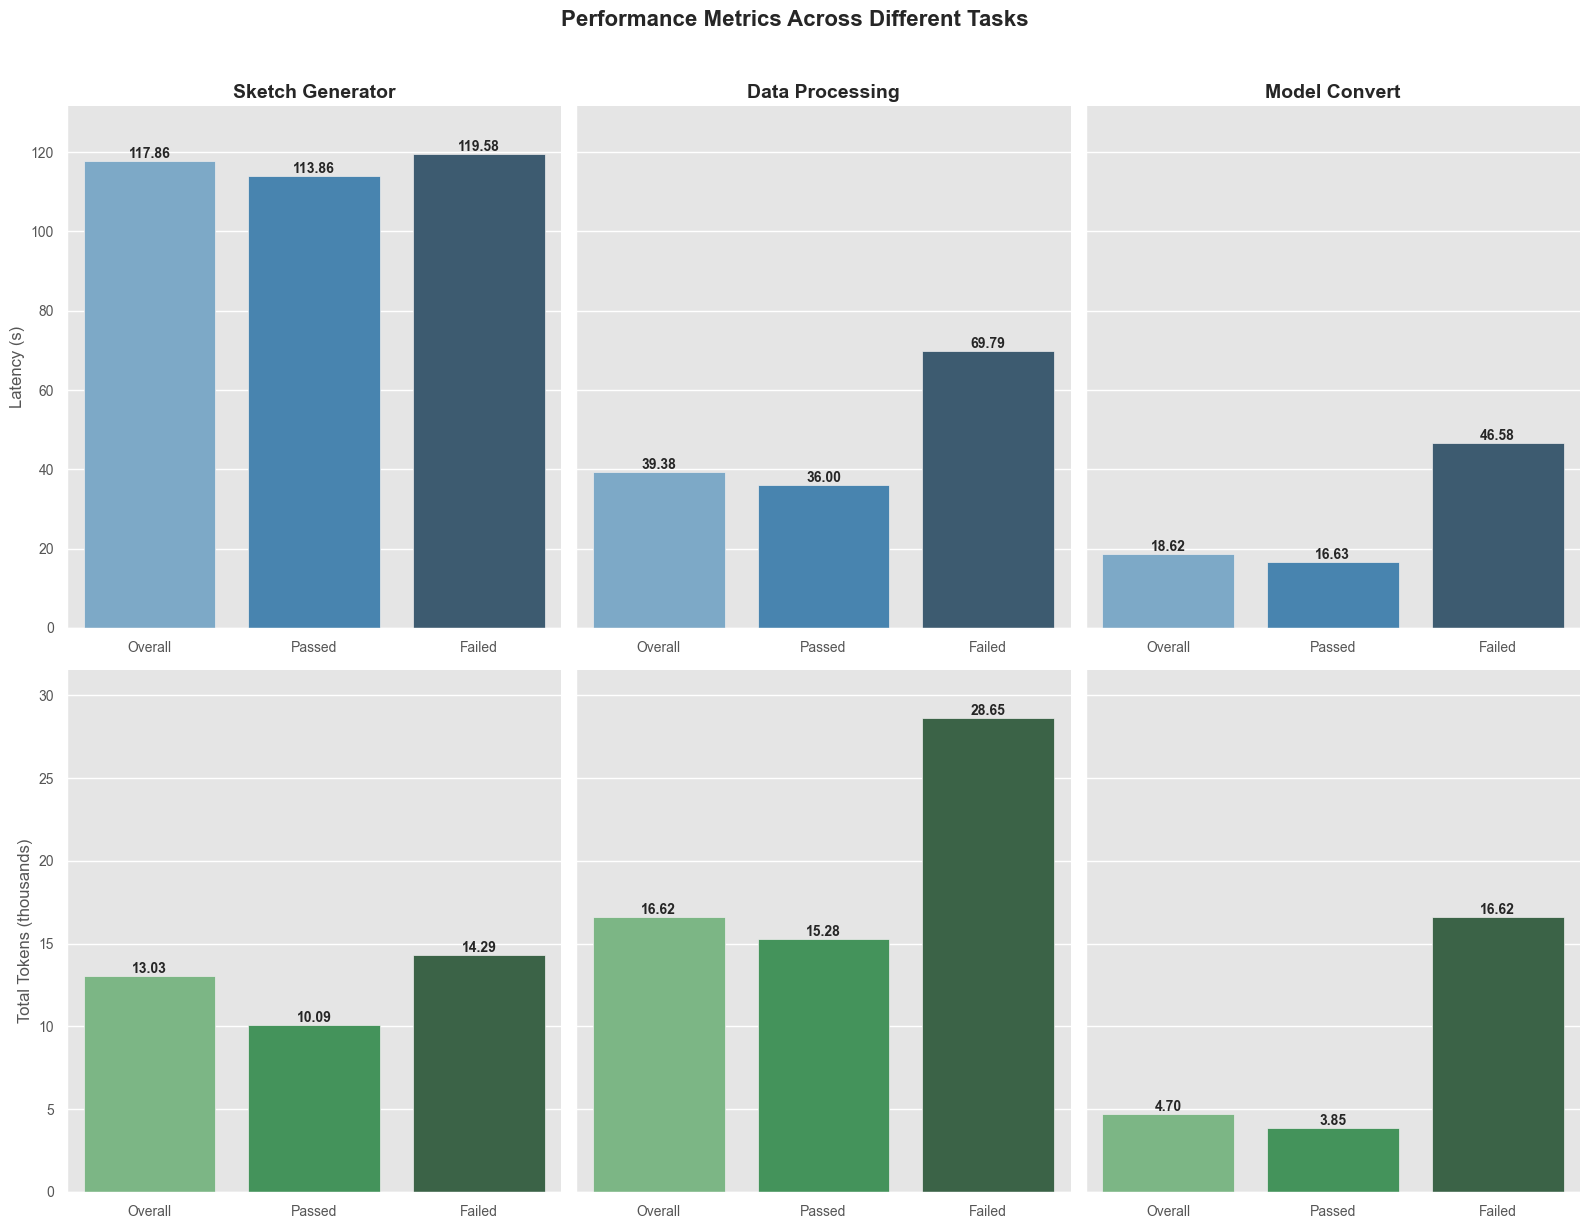

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load all datasets
df_sketch_generator = pd.read_csv(f"{data_dir}/sketch_generator.csv")
df_data_processing = pd.read_csv(f"{data_dir}/data_processing.csv")
df_model_convert = pd.read_csv(f"{data_dir}/model_convert.csv")


def calculate_stats(df, column):
    return {
        "average": df[column].mean(),
        "minimum": df[column].min(),
        "maximum": df[column].max(),
    }


def calculate_stats_by_status(df, status=None):
    if status is not None:
        subset = df[df["pass"] == status]
    else:
        subset = df
    return {
        "total_tokens": calculate_stats(subset, "total_tokens"),
        "latency": calculate_stats(subset, "latency"),
    }


def prepare_data_for_plot(df, task_name):
    overall_stats = calculate_stats_by_status(df)
    passed_stats = calculate_stats_by_status(df, "yes")
    failed_stats = calculate_stats_by_status(df, "no")

    data = []
    for metric in ["latency", "total_tokens"]:
        for status, stats in [
            ("Overall", overall_stats),
            ("Passed", passed_stats),
            ("Failed", failed_stats),
        ]:
            data.append(
                {
                    "Task": task_name,
                    "Metric": metric,
                    "Status": status,
                    "Average": stats[metric]["average"],
                    "Minimum": stats[metric]["minimum"],
                    "Maximum": stats[metric]["maximum"],
                }
            )
    return pd.DataFrame(data)


# Prepare data for plotting
df_sketch = prepare_data_for_plot(df_sketch_generator, "Sketch Generator")
df_data = prepare_data_for_plot(df_data_processing, "Data Processing")
df_model = prepare_data_for_plot(df_model_convert, "Model Convert")

# Combine all data
df_all = pd.concat([df_sketch, df_data, df_model])

# Determine global y-axis limits
latency_max = df_all[df_all["Metric"] == "latency"]["Average"].max()
tokens_max = df_all[df_all["Metric"] == "total_tokens"]["Average"].max()

# Set the style
plt.style.use("ggplot")
sns.set_palette("muted")

# Plotting
tasks = df_all["Task"].unique()
fig, axes = plt.subplots(nrows=2, ncols=len(tasks), figsize=(16, 12), sharey="row")

for col, task in enumerate(tasks):
    task_data = df_all[df_all["Task"] == task]

    # Plot latency
    ax_latency = axes[0, col]
    latency_data = task_data[task_data["Metric"] == "latency"]
    x = np.arange(len(latency_data["Status"]))
    bars1 = sns.barplot(
        x="Status", y="Average", data=latency_data, ax=ax_latency, palette="Blues_d"
    )
    ax_latency.set_ylabel("Latency (s)" if col == 0 else "")
    ax_latency.set_ylim(0, latency_max * 1.1)  # Add some padding
    ax_latency.set_title(task, fontsize=14, fontweight="bold")

    # Annotate latency bars
    for i, bar in enumerate(bars1.patches):
        yval = bar.get_height()
        ax_latency.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
            fontweight="bold",
        )

    # Plot total tokens
    ax_tokens = axes[1, col]
    tokens_data = task_data[task_data["Metric"] == "total_tokens"]
    bars2 = sns.barplot(
        x="Status", y="Average", data=tokens_data, ax=ax_tokens, palette="Greens_d"
    )
    ax_tokens.set_ylabel("Total Tokens (thousands)" if col == 0 else "")
    ax_tokens.set_ylim(0, tokens_max * 1.1)  # Add some padding
    ax_tokens.set_yticklabels([f"{int(tick/1000)}" for tick in ax_tokens.get_yticks()])

    # Annotate token bars
    for i, bar in enumerate(bars2.patches):
        yval = bar.get_height()
        ax_tokens.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval/1000:.2f}",
            ha="center",
            va="bottom",
            fontweight="bold",
        )

    # Improve readability
    for ax in [ax_latency, ax_tokens]:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis="both", which="major", labelsize=10)
        ax.set_xlabel("")

# Add overall title
fig.suptitle(
    "Performance Metrics Across Different Tasks", fontsize=16, fontweight="bold", y=1.02
)

# Adjust layout
plt.tight_layout()
plt.show()

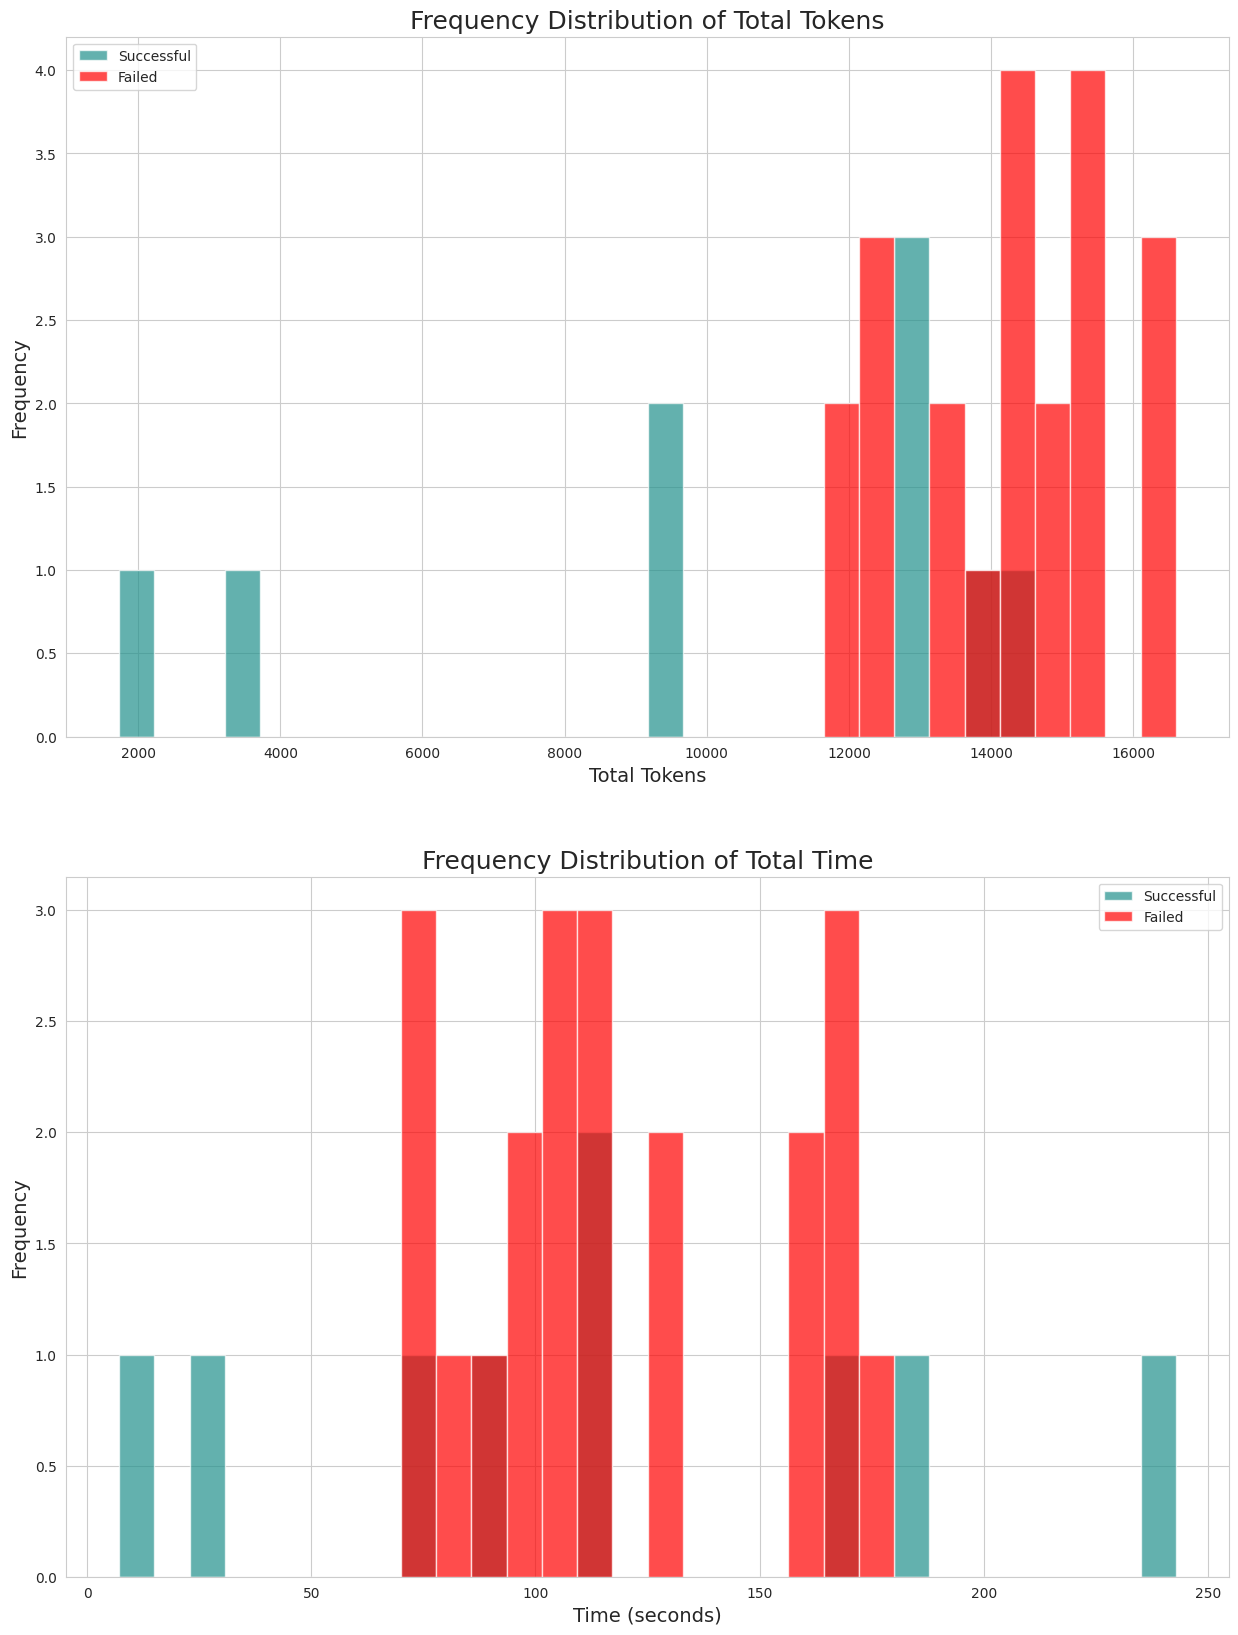

Total number of runs: 30
Number of successful runs: 9
Number of failed runs: 21
Success rate: 30.00%
Failure rate: 70.00%


In [147]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your input DataFrame

# Set the style
sns.set_style("whitegrid")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))


# Function to plot histogram with highlighted failures and matched bar widths
def plot_histogram(data, x, ax, title, xlabel):
    # Determine the range and number of bins
    min_val = data[x].min()
    max_val = data[x].max()
    num_bins = 30
    bins = np.linspace(min_val, max_val, num_bins + 1)

    # Plot successful runs
    ax.hist(
        data[data["pass"] == "yes"][x],
        bins=bins,
        alpha=0.7,
        color=sns.color_palette("viridis", as_cmap=True)(0.5),
        label="Successful",
    )

    # Plot failed runs
    ax.hist(
        data[data["pass"] != "yes"][x],
        bins=bins,
        alpha=0.7,
        color="red",
        label="Failed",
    )

    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.legend()


# Plot 1: Frequency Distribution of Total Tokens
plot_histogram(
    df, "total_tokens", ax1, "Frequency Distribution of Total Tokens", "Total Tokens"
)

# Plot 2: Frequency Distribution of Total Latency
plot_histogram(
    df, "latency", ax2, "Frequency Distribution of Total Time", "Time (seconds)"
)

# Adjust layout and display the plot
# plt.tight_layout()
plt.show()

# Print summary statistics
total_runs = len(df)
successful_runs = len(df[df["pass"] == "yes"])
failed_runs = len(df[df["pass"] != "yes"])

print(f"Total number of runs: {total_runs}")
print(f"Number of successful runs: {successful_runs}")
print(f"Number of failed runs: {failed_runs}")
print(f"Success rate: {successful_runs / total_runs * 100:.2f}%")
print(f"Failure rate: {failed_runs / total_runs * 100:.2f}%")

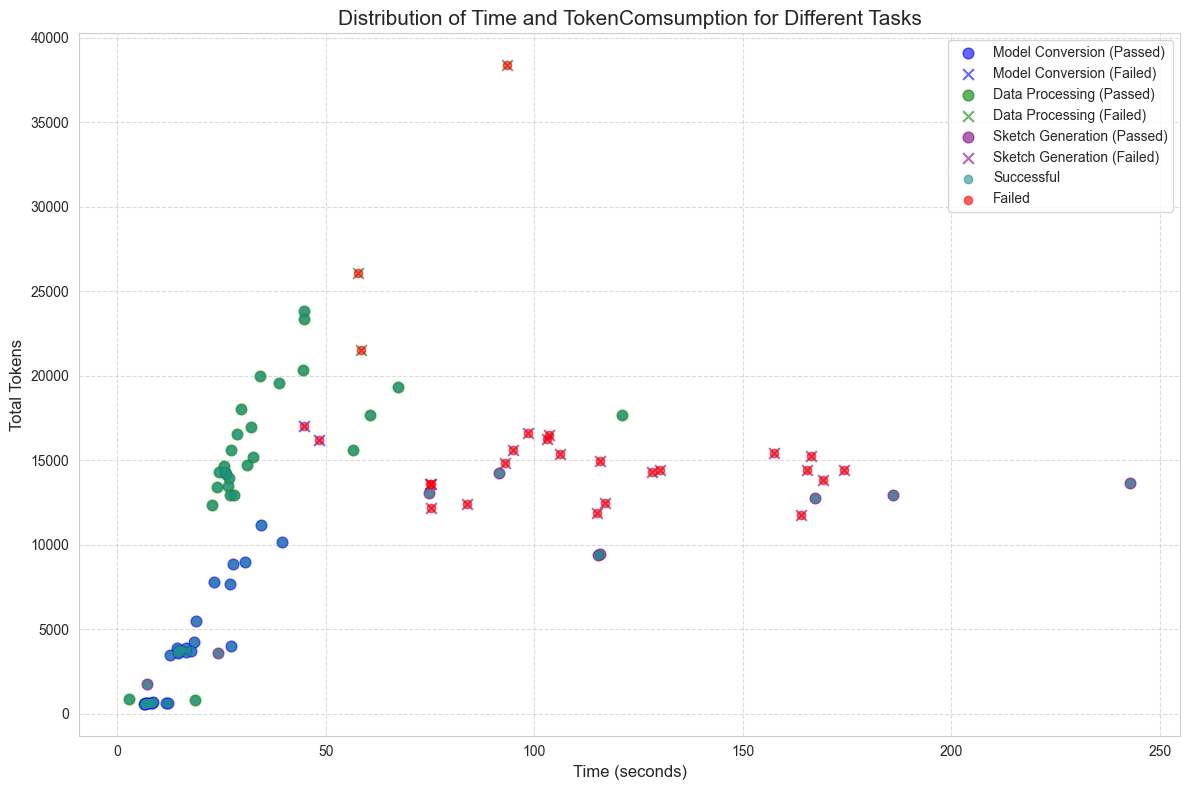

Total number of runs: 90
Number of successful runs: 64
Number of failed runs: 26
Success rate: 71.11%
Failure rate: 28.89%

Averages for successful runs:
Average latency: 38.47 seconds
Average total tokens: 9551.78

Averages for failed runs:
Average latency: 108.22 seconds
Average total tokens: 16123.65


In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_dir = "processed_data"
# Load the data from CSV files
df_sketch_generator = pd.read_csv(f"{data_dir}/sketch_generator.csv")
df_data_processing = pd.read_csv(f"{data_dir}/data_processing.csv")
df_model_convert = pd.read_csv(f"{data_dir}/model_convert.csv")

# Combine all dataframes into a single dataframe with an additional 'task' column
df_sketch_generator["task"] = "Sketch Generation"
df_data_processing["task"] = "Data Processing"
df_model_convert["task"] = "Model Conversion"

df_combined = pd.concat([df_sketch_generator, df_data_processing, df_model_convert])

# Assuming df is your input DataFrame

# Set the style
sns.set_style("whitegrid")

# Create the figure
plt.figure(figsize=(12, 8))

# Define colors and markers for each task
task_colors = {
    "Model Conversion": "blue",
    "Data Processing": "green",
    "Sketch Generation": "purple",
}

task_markers = {
    "yes": "o",  # Circle for successful runs
    "no": "x",  # Cross for failed runs
}

# Plot each task with different colors and markers
for task, color in task_colors.items():
    for pass_status, marker in task_markers.items():
        subset = df_combined[
            (df_combined["task"] == task) & (df_combined["pass"] == pass_status)
        ]
        plt.scatter(
            subset["latency"],
            subset["total_tokens"],
            color=color,
            alpha=0.6,
            label=f"{task} ({'Passed' if pass_status == 'yes' else 'Failed'})",
            marker=marker,
            s=60,
        )
# Create the scatter plot
successful_runs = df_combined[df_combined["pass"] == "yes"]
failed_runs = df_combined[df_combined["pass"] != "yes"]

plt.scatter(
    successful_runs["latency"],
    successful_runs["total_tokens"],
    color=sns.color_palette("viridis", as_cmap=True)(0.5),
    alpha=0.6,
    label="Successful",
)
plt.scatter(
    failed_runs["latency"],
    failed_runs["total_tokens"],
    color="red",
    alpha=0.6,
    label="Failed",
)

# Set labels and title
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Total Tokens", fontsize=12)
plt.title("Distribution of Time and TokenComsumption for Different Tasks", fontsize=15)

# Add legend
plt.legend(fontsize=10, loc="upper right")

# Add grid
plt.grid(True, linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

# Print summary statistics
total_runs = len(df_combined)
successful_runs_count = len(successful_runs)
failed_runs_count = len(failed_runs)

print(f"Total number of runs: {total_runs}")
print(f"Number of successful runs: {successful_runs_count}")
print(f"Number of failed runs: {failed_runs_count}")
print(f"Success rate: {successful_runs_count / total_runs * 100:.2f}%")
print(f"Failure rate: {failed_runs_count / total_runs * 100:.2f}%")

# Calculate and print averages
print("\nAverages for successful runs:")
print(f"Average latency: {successful_runs['latency'].mean():.2f} seconds")
print(f"Average total tokens: {successful_runs['total_tokens'].mean():.2f}")

print("\nAverages for failed runs:")
print(f"Average latency: {failed_runs['latency'].mean():.2f} seconds")
print(f"Average total tokens: {failed_runs['total_tokens'].mean():.2f}")

In [149]:
import os

print(os.getcwd())
print(os.listdir("."))

/home/han/Projects/tinyml-autopilot/dev/test_in_batch/2_oct
['plot.pdf', 'batch_run.py', 'sketch_generator.csv', 'langsmith_export.ipynb', 'data_processing.csv', 'sample_plot.pdf', 'model_convert.csv']


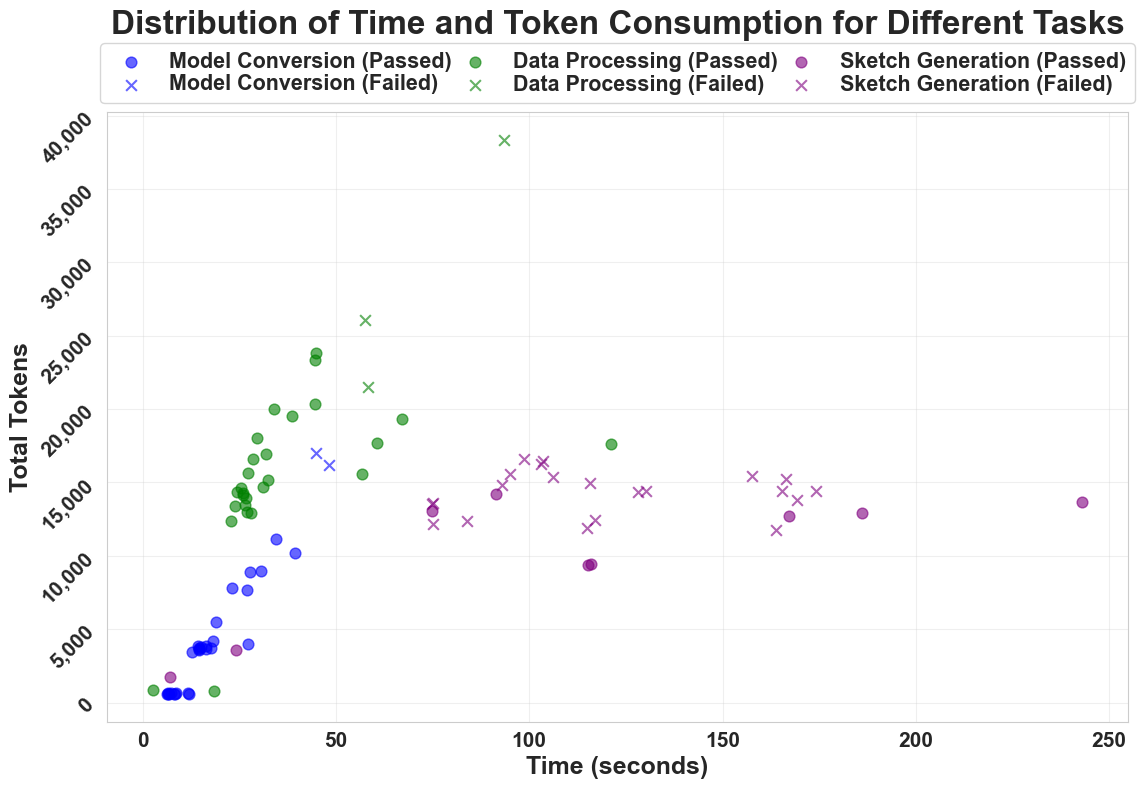

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42

data_dir = "processed_data"
# Load the data from CSV files
df_sketch_generator = pd.read_csv(f"{data_dir}/sketch_generator.csv")
df_data_processing = pd.read_csv(f"{data_dir}/data_processing.csv")
df_model_convert = pd.read_csv(f"{data_dir}/model_convert.csv")

# Combine all dataframes into a single dataframe with an additional 'task' column
df_sketch_generator["task"] = "Sketch Generation"
df_data_processing["task"] = "Data Processing"
df_model_convert["task"] = "Model Conversion"

df_combined = pd.concat([df_sketch_generator, df_data_processing, df_model_convert])


df_combined = pd.concat([df_sketch_generator, df_data_processing, df_model_convert])

# Set the style
sns.set_style("whitegrid")

# Create the figure
plt.figure(figsize=(12, 8))

# Define colors and markers for each task
task_colors = {
    "Model Conversion": "blue",
    "Data Processing": "green",
    "Sketch Generation": "purple",
}

task_markers = {
    "yes": "o",  # Circle for successful runs
    "no": "x",  # Cross for failed runs
}

# Plot each task with different colors and markers
for task, color in task_colors.items():
    for pass_status, marker in task_markers.items():
        subset = df_combined[
            (df_combined["task"] == task) & (df_combined["pass"] == pass_status)
        ]
        plt.scatter(
            subset["latency"],
            subset["total_tokens"],
            color=color,
            alpha=0.6,
            label=f"{task} ({'Passed' if pass_status == 'yes' else 'Failed'})",
            marker=marker,
            s=60,
        )

# Set labels and title
plt.xlabel("Time (seconds)", fontsize=18, fontweight="bold")
plt.ylabel("Total Tokens", fontsize=18, fontweight="bold")
plt.title(
    "Distribution of Time and Token Consumption for Different Tasks",
    fontsize=24,
    loc="center",
    x=0.5,  # Horizontal position (0 is left, 1 is right)
    y=1.114,
    fontweight="bold",
)
plt.tick_params(
    axis="both",
    which="major",
    labelsize=15,
)

# Format the y-axis numbers with commas
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{int(y):,}"))

# Format the x-axis numbers with commas if needed
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

# Add legend
plt.yticks(rotation=45, ha="right", fontweight="bold")
plt.xticks(fontweight="bold")
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.13),
    ncol=3,
    columnspacing=0.05,
    labelspacing=0.1,
    prop={"weight": "bold", "size": 15.5},
)

# Add grid
plt.grid(True, linestyle="-", alpha=0.3)

# Show the plot
plt.tight_layout()
plt.savefig("plot.pdf", format="pdf", dpi=300)
plt.show()

(array([-50.,   0.,  50., 100., 150., 200., 250., 300.]),
 [Text(-50.0, 0, '-50'),
  Text(0.0, 0, '0'),
  Text(50.0, 0, '50'),
  Text(100.0, 0, '100'),
  Text(150.0, 0, '150'),
  Text(200.0, 0, '200'),
  Text(250.0, 0, '250'),
  Text(300.0, 0, '300')])

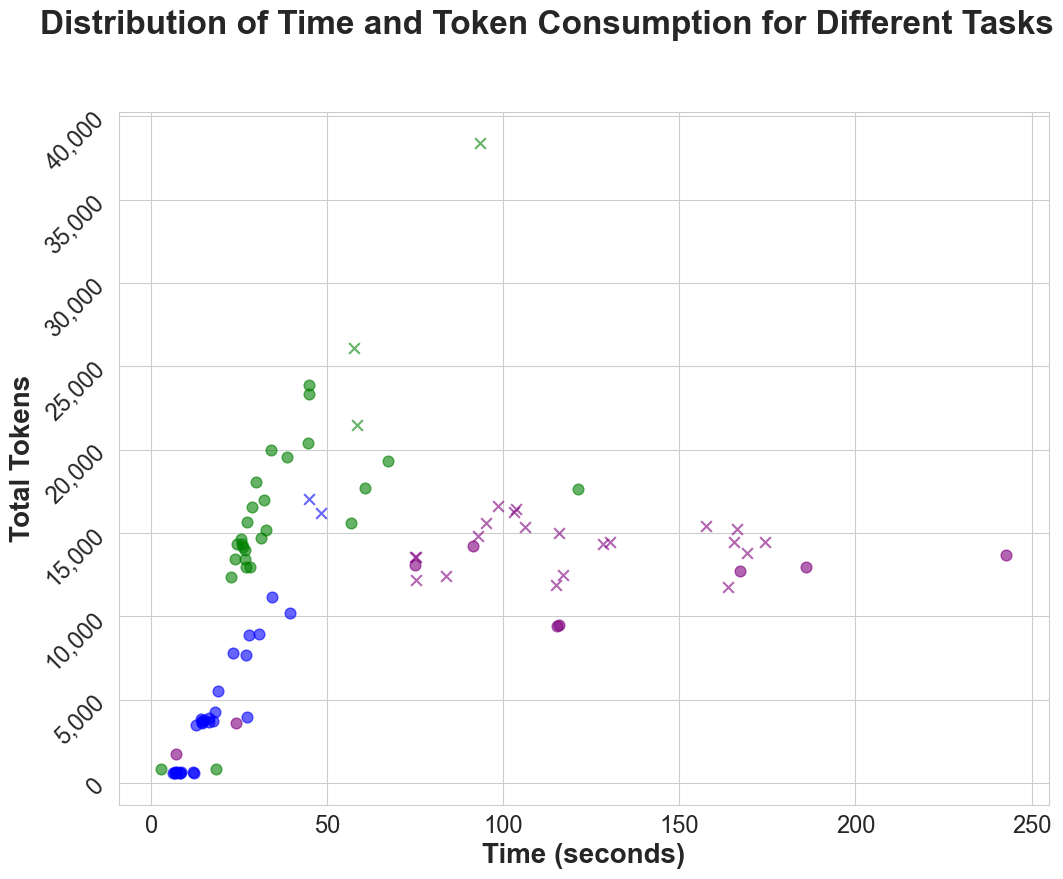

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker

title_fontweight = 800
label_fontweight = 600
tick_fontweight = 400
legend_fontweight = "normal"
legend_fontweight2 = "normal"
title_fontsize = 24
label_fontsize = 20
tick_fontsize = 18
legend_fontsize = 16

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
data_dir = "processed_data"
# Load the data from CSV files
df_sketch_generator = pd.read_csv(f"{data_dir}/sketch_generator.csv")
df_data_processing = pd.read_csv(f"{data_dir}/data_processing.csv")
df_model_convert = pd.read_csv(f"{data_dir}/model_convert.csv")

# Combine all dataframes into a single dataframe with an additional 'task' column
df_sketch_generator["task"] = "Sketch Generation"
df_data_processing["task"] = "Data Processing"
df_model_convert["task"] = "Model Conversion"

df_combined = pd.concat([df_sketch_generator, df_data_processing, df_model_convert])

# Set the style
sns.set_style("whitegrid")

# Create the figure
plt.figure(figsize=(12, 9))

# Define colors and markers for each task
task_colors = {
    "Model Conversion": "blue",
    "Data Processing": "green",
    "Sketch Generation": "purple",
}

task_markers = {
    "yes": "o",  # Circle for successful runs
    "no": "x",  # Cross for failed runs
}

# Plot each task with different colors and markers
for task, color in task_colors.items():
    task_data = df_combined[df_combined["task"] == task]

    # Plot passed runs
    passed = task_data[task_data["pass"] == "yes"]
    plt.scatter(
        passed["latency"],
        passed["total_tokens"],
        color=color,
        alpha=0.6,
        label=task,  # Label only with task name
        marker="o",  # Circle for passed
        s=60,
    )

    # Plot failed runs without labels (to avoid task repetition in legend)
    failed = task_data[task_data["pass"] == "no"]
    plt.scatter(
        failed["latency"],
        failed["total_tokens"],
        color=color,
        alpha=0.6,
        marker="x",  # X for failed
        s=60,
    )

# Set labels and title
plt.xlabel("Time (seconds)", fontsize=label_fontsize, fontweight=label_fontweight)
plt.ylabel("Total Tokens", fontsize=label_fontsize, fontweight=label_fontweight)
plt.title(
    "Distribution of Time and Token Consumption for Different Tasks",
    fontsize=title_fontsize,
    loc="center",
    x=0.46,
    y=1.1,
    fontweight=title_fontweight,
)
plt.tick_params(
    axis="both",
    which="major",
    labelsize=17,
)

# Format the y-axis numbers with commas
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{int(y):,}"))

# Format the x-axis numbers with commas if needed
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
# Add separate pass/fail markers to legend
plt.scatter([], [], color="gray", marker="o", label="Passed", s=60)
plt.scatter([], [], color="gray", marker="x", label="Failed", s=60)

# Add legend
plt.yticks(rotation=45, ha="right", fontweight=tick_fontweight)
plt.xticks(fontweight=tick_fontweight)

## Plot vertical legend


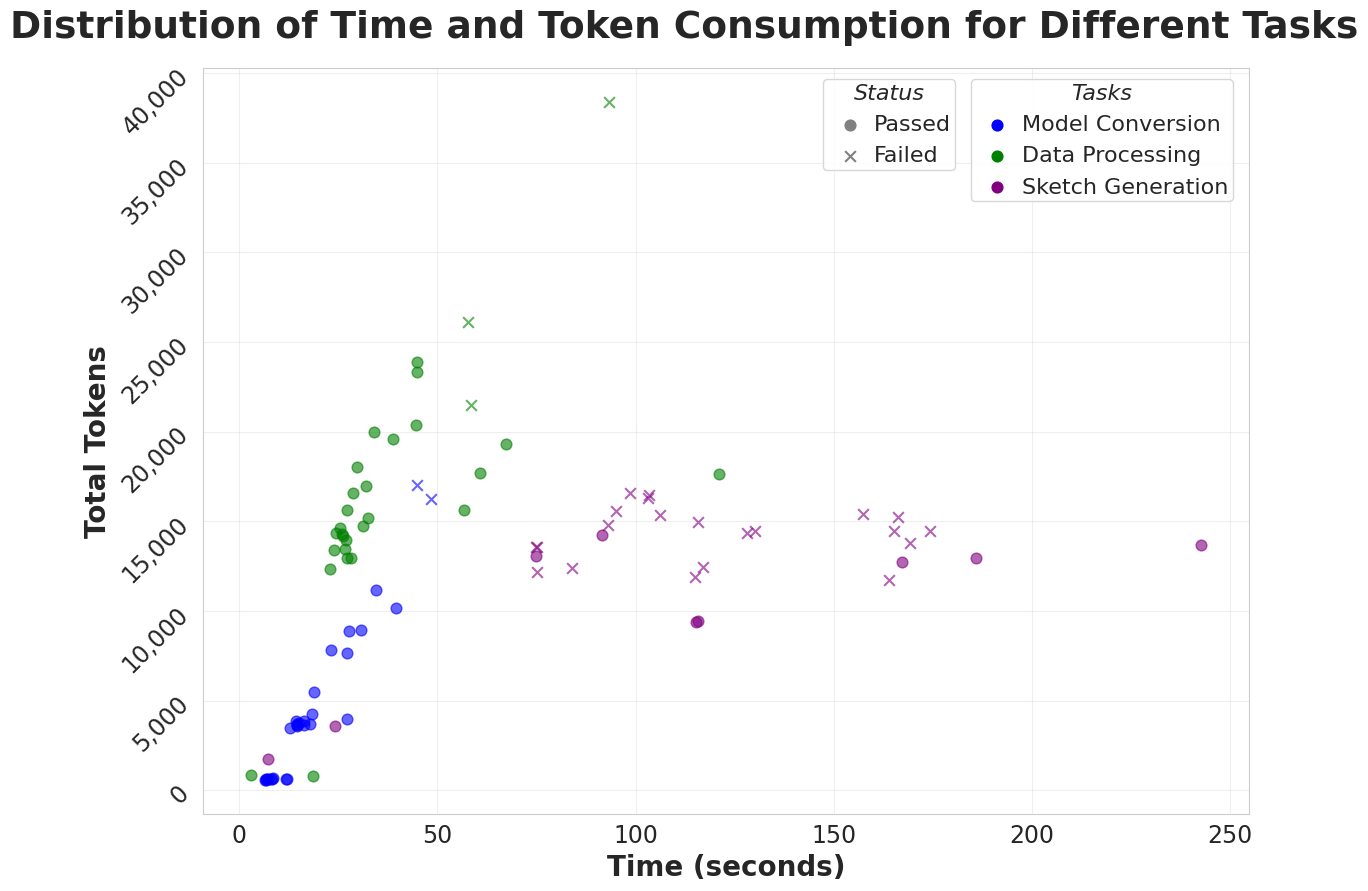

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker

title_fontweight = 800
label_fontweight = 600
tick_fontweight = 400
legend_fontweight = "normal"
legend_fontweight2 = "normal"

title_fontsize = 27
label_fontsize = 20
tick_fontsize = 18
legend_fontsize = 16

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
data_dir = "processed_data"
# Load the data from CSV files
df_sketch_generator = pd.read_csv(f"{data_dir}/sketch_generator.csv")
df_data_processing = pd.read_csv(f"{data_dir}/data_processing.csv")
df_model_convert = pd.read_csv(f"{data_dir}/model_convert.csv")

# Combine all dataframes into a single dataframe with an additional 'task' column
df_sketch_generator["task"] = "Sketch Generation"
df_data_processing["task"] = "Data Processing"
df_model_convert["task"] = "Model Conversion"

df_combined = pd.concat([df_sketch_generator, df_data_processing, df_model_convert])

# Set the style
sns.set_style("whitegrid")

# Create the figure
plt.figure(figsize=(12, 9))

# Define colors and markers for each task
task_colors = {
    "Model Conversion": "blue",
    "Data Processing": "green",
    "Sketch Generation": "purple",
}

task_markers = {
    "yes": "o",  # Circle for successful runs
    "no": "x",  # Cross for failed runs
}

# Plot each task with different colors and markers
for task, color in task_colors.items():
    task_data = df_combined[df_combined["task"] == task]

    # Plot passed runs
    passed = task_data[task_data["pass"] == "yes"]
    plt.scatter(
        passed["latency"],
        passed["total_tokens"],
        color=color,
        alpha=0.6,
        label=task,  # Label only with task name
        marker="o",  # Circle for passed
        s=60,
    )

    # Plot failed runs without labels (to avoid task repetition in legend)
    failed = task_data[task_data["pass"] == "no"]
    plt.scatter(
        failed["latency"],
        failed["total_tokens"],
        color=color,
        alpha=0.6,
        marker="x",  # X for failed
        s=60,
    )

# Set labels and title
plt.xlabel("Time (seconds)", fontsize=label_fontsize, fontweight=label_fontweight)
plt.ylabel("Total Tokens", fontsize=label_fontsize, fontweight=label_fontweight)
plt.title(
    "Distribution of Time and Token Consumption for Different Tasks",
    fontsize=title_fontsize,
    loc="center",
    x=0.46,
    y=1.03,
    fontweight=title_fontweight,
)
plt.tick_params(
    axis="both",
    which="major",
    labelsize=17,
)

# Format the y-axis numbers with commas
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{int(y):,}"))

# Format the x-axis numbers with commas if needed
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
# Add separate pass/fail markers to legend
plt.scatter([], [], color="gray", marker="o", label="Passed", s=60)
plt.scatter([], [], color="gray", marker="x", label="Failed", s=60)

# Add legend
plt.yticks(rotation=45, ha="right", fontweight=tick_fontweight)
plt.xticks(fontweight=tick_fontweight)
# ... existing code until the legend section ...

# ... existing code remains the same until legend section ...

# Create two separate legend handles and labels
task_handles = []
task_labels = []
status_handles = []
status_labels = []

# Collect task handles and labels
for task, color in task_colors.items():
    task_handles.append(plt.scatter([], [], color=color, marker="o", s=60))
    task_labels.append(task)

# Add status handles and labels
status_handles.append(plt.scatter([], [], color="gray", marker="o", s=60))
status_handles.append(plt.scatter([], [], color="gray", marker="x", s=60))
status_labels.extend(["Passed", "Failed"])

legend_title_prop = {
    "weight": legend_fontweight,
    "size": legend_fontsize,
    "style": "italic",
}


# Create legend with two handle/label sets side by side
first_legend = plt.legend(
    task_handles,
    task_labels,
    loc="upper right",
    bbox_to_anchor=(0.995, 1.0),  # Position for first legend
    prop={"weight": legend_fontweight, "size": legend_fontsize},
    frameon=True,
    scatterpoints=1,
    markerscale=1,
    markerfirst=True,
    handletextpad=0.1,
    borderpad=0.2,
    edgecolor="lightgray",
    fancybox=True,
    shadow=False,
    framealpha=0.9,
    title="Tasks",
    title_fontproperties=legend_title_prop,
)

# Add the second legend for status markers
plt.gca().add_artist(first_legend)
plt.legend(
    status_handles,
    status_labels,
    loc="upper right",
    bbox_to_anchor=(
        0.73,
        1.0,
    ),  # Position for second legend - adjust this value to control horizontal spacing
    prop={"weight": legend_fontweight, "size": legend_fontsize},
    frameon=True,
    scatterpoints=1,
    markerscale=1,
    markerfirst=True,
    handletextpad=0.1,
    borderpad=0.2,
    edgecolor="lightgray",
    fancybox=True,
    shadow=False,
    framealpha=0.9,
    title="Status",
    title_fontproperties=legend_title_prop,
)

# ... rest of the code remains the same ...

# Add grid and show plot
plt.grid(True, linestyle="-", alpha=0.3)
plt.tight_layout()
plt.savefig(
    "plot.pdf", format="pdf", dpi=400
)  # Removed bbox_inches='tight' as it's no longer needed
plt.show()

## Replot with plotnine


/home/han/anaconda3/envs/llmdev/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/han/anaconda3/envs/llmdev/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plot.pdf
/tmp/ipykernel_1324310/649277900.py:66: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


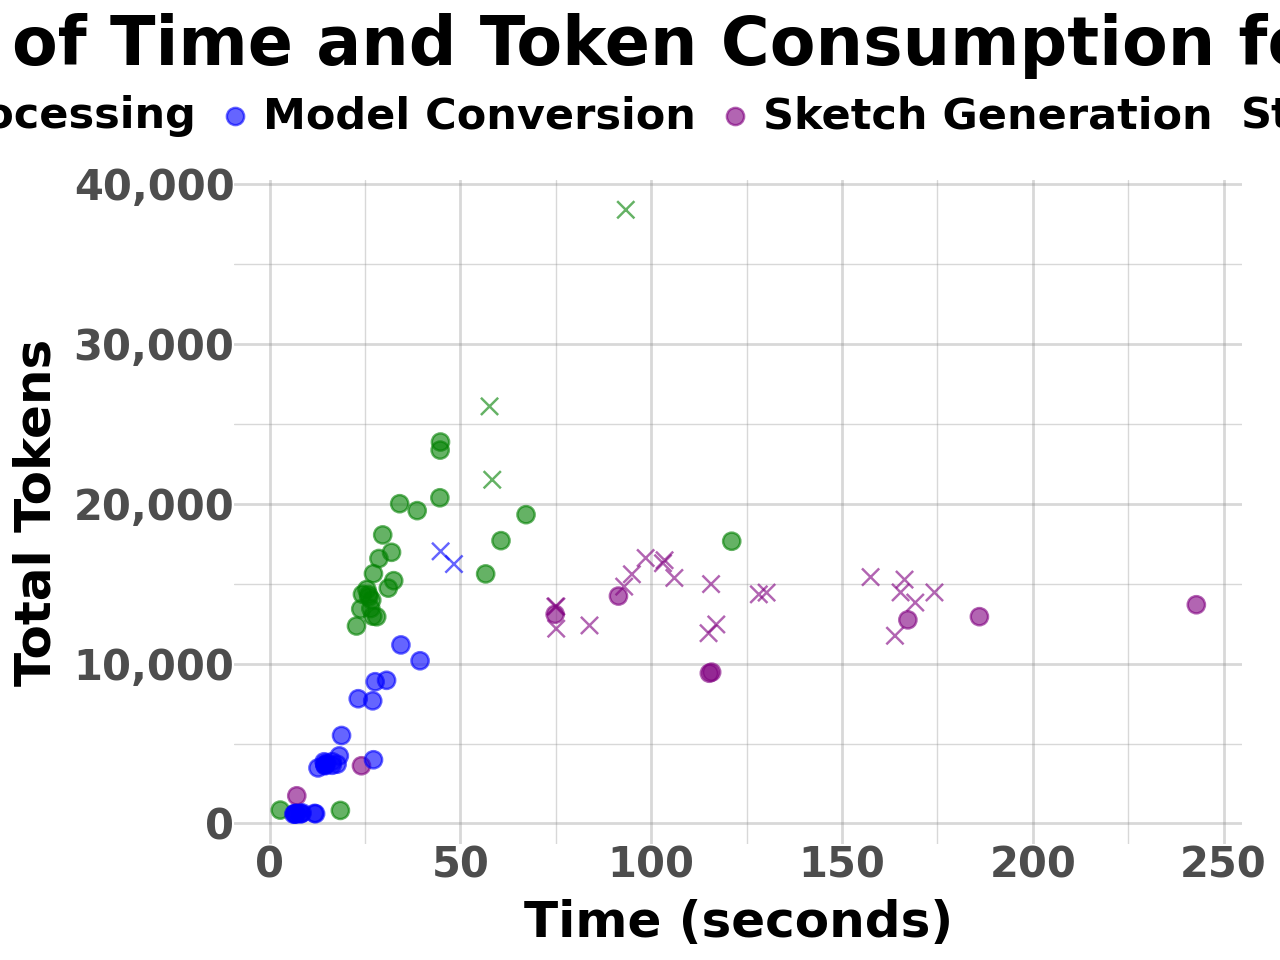

In [110]:
from plotnine import *
import pandas as pd
import matplotlib as mpl

# Font settings
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42

# Load and prepare data
data_dir = "processed_data/"
df_sketch_generator = pd.read_csv(f"{data_dir}/sketch_generator.csv")
df_data_processing = pd.read_csv(f"{data_dir}/data_processing.csv")
df_model_convert = pd.read_csv(f"{data_dir}/model_convert.csv")

# Add task labels
df_sketch_generator["task"] = "Sketch Generation"
df_data_processing["task"] = "Data Processing"
df_model_convert["task"] = "Model Conversion"

# Combine dataframes
df_combined = pd.concat([df_sketch_generator, df_data_processing, df_model_convert])

# Create pass_label column for better legend
df_combined["pass_label"] = df_combined["pass"].map({"yes": "Passed", "no": "Failed"})

# Create the plot
plot = (
    ggplot(
        df_combined,
        aes(x="latency", y="total_tokens", color="task", shape="pass_label"),
    )
    + geom_point(size=3, alpha=0.6)
    + scale_color_manual(
        values={
            "Model Conversion": "blue",
            "Data Processing": "green",
            "Sketch Generation": "purple",
        }
    )
    + scale_shape_manual(values={"Passed": "o", "Failed": "x"})
    + labs(
        title="Distribution of Time and Token Consumption for Different Tasks",
        x="Time (seconds)",
        y="Total Tokens",
        color="Task",
        shape="Status",
    )
    + theme_minimal()
    + theme(
        plot_title=element_text(size=24, face="bold", hjust=0.5),
        axis_title_x=element_text(size=18, face="bold"),
        axis_title_y=element_text(size=18, face="bold"),
        axis_text=element_text(size=15, face="bold"),
        legend_title=element_text(size=15.5, face="bold"),
        legend_text=element_text(size=15.5, face="bold"),
        legend_position="top",
        panel_grid_major=element_line(color="gray", alpha=0.3),
        panel_grid_minor=element_line(color="gray", alpha=0.3),
    )
    + scale_y_continuous(labels=lambda l: [f"{int(v):,}" for v in l])
    + scale_x_continuous(labels=lambda l: [f"{int(v):,}" for v in l])
)

# Save and display the plot
plot.save("plot.pdf", dpi=300)
print(plot)